# 005: Finding out how many of the ground truths actually contain congestions
* Or in a way, how many actually caused congestions based on speed data
* This was used to generate **Figure 7**: `Distribution of ground truth incident data and distance of the nearest detected congestion (in minutes)` in the paper

## Steps:
1. Gather all speed data
2. Gather all incidents
3. Loop through incidents and get the data for that day
4. Set some time period around that incident (ie. $\pm 2$ hours)
    * See how many dips the difference between consecutive values gives.
    * We are interested in the first dip and the next dip (or is it last?)
    * If no dips, then the incident did not have any effect.
5. Get data such as how long before or after the ground truth was the congestion first detected
    * How long after the ground truth did the congestion disappear (if it did)
6. Future: See if this was due to recurring congestion
7. Create a dataframe with these values.

## Notes:
* Also check nearby (geographical) segments in case it was wrongly assigned

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import pickle
import sys
import time
import networkx as nx
from copy import deepcopy
from tqdm.notebook import tqdm
from shapely.geometry import LineString, Point, Polygon

sys.path.append("..")
from src.utils import Read_DF, Call_Back
from src import cleaning_data

In [6]:
if not os.path.exists(os.path.join(os.getcwd(), '../data')):
    raise OSError("Must first download data, see README.md")
data_dir = os.path.join(os.getcwd(), '../data')

if not os.path.exists(os.path.join(os.getcwd(), '../img')):
    raise OSError("Must first download data, see README.md")
img_dir = os.path.join(os.getcwd(), '../img')

if not os.path.exists(os.path.join(data_dir, 'segment_network_graphs')):
    os.mkdir(os.path.join(data_dir, 'segment_network_graphs'))
graphs_dir = os.path.join(data_dir, 'segment_network_graphs')

if not os.path.exists(os.path.join(data_dir, 'speed_data')):
    os.mkdir(os.path.join(data_dir, 'speed_data'))
speed_dir = os.path.join(data_dir, 'speed_data')

### Loading Inrix data

In [7]:
fp = os.path.join(data_dir, 'overall_means.pkl')
df_overall_all = pd.read_pickle(fp)
active_segments = df_overall_all.droplevel([0, 1]).reset_index()['XDSegID'].unique().tolist()
fp = os.path.join(data_dir, 'inrix_grouped.pkl')
inrix_df = pd.read_pickle(fp)
inrix_df = inrix_df.set_geometry('geometry')

inrix_df.set_crs(epsg=4326, inplace=True, allow_override=True)

# limit to available data sources
clusters_df = inrix_df.loc[inrix_df['XDSegID'].isin(active_segments)]

# inrix_df = inrix_df.to_crs('EPSG:3857')
# inrix_df = inrix_df.to_crs('EPSG:4326')

begs = []
ends = []
for i in range(len(clusters_df)):
    begs.append(Point(clusters_df.iloc[i]['StartLong'], clusters_df.iloc[i]['StartLat']))
    ends.append(Point(clusters_df.iloc[i]['EndLong'], clusters_df.iloc[i]['EndLat']))
    
clusters_df['Beg'] = begs
clusters_df['End'] = ends
clusters_df['center'] = clusters_df['geometry'].centroid

/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)
<ipython-input-7-1671588d9dd1>:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters_df['center'] = clusters_df['geometry'].centroid


### Loading segment graph

In [8]:
fp = os.path.join(graphs_dir, 'line_segment_graph.pkl')
L_XDSegID = nx.read_gpickle(fp)
print(nx.info(L_XDSegID))

Name: 
Type: MultiDiGraph
Number of nodes: 6906
Number of edges: 15264
Average in degree:   2.2103
Average out degree:   2.2103


### Load incident ground truths

In [16]:
fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
df_incidents_gt = pd.read_pickle(fp)
df_incidents_gt.head()

,XDSegID,Total_Number_Incidents
time_local,,
2019-01-01 01:10:00,1524461437,1
2019-01-01 01:15:00,441420536,1
2019-01-01 02:00:00,449626583,1
2019-01-01 02:05:00,1524395080,1
2019-01-01 16:30:00,1524581409,1


## Putting it all together
* Doing it per month first
* Problem is it is getting the largest congestion and not the nearest, but guess nothing cna do
* Also only getting one congestion
* Need to fix when there is no congestion, there is out of bounds


## Test data
* [5:] Must get the congestion ahead of the incident instead of the one behind
* [7:] No incident-caused congestion

# REALLY PUTTING IT TOGETHER
* Dataframe output
* Save config to somewhere

In [17]:
df_overall = []
to_months = 2 #13
for month in tqdm(range(1, to_months)):
    fp = os.path.join(speed_dir, f'ALL_5m_DF_2019_{month}_1.gzip')
    DF_1 = Read_DF(DF_All = fp, Reading_Tag = 'DF_All', MetaData = {})

    fp = os.path.join(speed_dir, f'ALL_5m_DF_2019_{month}_15.gzip')
    DF_15 = Read_DF(DF_All = fp, Reading_Tag = 'DF_All', MetaData = {})

    df_month_all = pd.concat([DF_1, DF_15])

    df_overall.append(df_month_all)
    
# df_overall_all = pd.concat([df.reset_index() for df in df_overall])

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
df_overall[month - 1]

,year,month,day,window,XDSegID,time_local,Time_id,Space_id,ID_Seg_win_DF,congestion_mean,...,cvalue_mean,confidence_score_mean,FRC,MyGrouping_3,temp_mean,wind_spd_mean,vis_mean,precip_mean,Total_Number_Incidents,time_utc
0,2019,1,1,0,155711459,2019-01-01 00:00:00,0,0,0,NaN,...,NaN,NaN,4,8109150,13.3,4.8,5.0,0.0,0,2019-01-01 06:00:00
1,2019,1,1,0,155716829,2019-01-01 00:00:00,0,1,7763,NaN,...,NaN,NaN,4,8110027,13.3,4.8,5.0,0.0,0,2019-01-01 06:00:00
2,2019,1,1,0,155725149,2019-01-01 00:00:00,0,2,2563,NaN,...,NaN,NaN,4,8109145,13.3,4.8,5.0,0.0,0,2019-01-01 06:00:00
3,2019,1,1,0,155730113,2019-01-01 00:00:00,0,3,2561,NaN,...,NaN,NaN,4,8107390,13.3,4.8,5.0,0.0,0,2019-01-01 06:00:00
4,2019,1,1,0,155742183,2019-01-01 00:00:00,0,4,2558,NaN,...,NaN,NaN,4,8106100,12.0,4.8,5.0,0.0,0,2019-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38051707,2019,1,31,287,1524644585,2019-01-31 23:55:00,4895,7767,38049127,0.0,...,93.8,30.0,0,8105676,3.0,8.8,1.0,0.0,0,2019-02-01 05:55:00
38051708,2019,1,31,287,1524645372,2019-01-31 23:55:00,4895,7768,38043942,0.0,...,NaN,20.0,1,8109580,3.9,8.8,1.0,0.0,0,2019-02-01 05:55:00
38051709,2019,1,31,287,1524646416,2019-01-31 23:55:00,4895,7769,38049768,0.0,...,NaN,20.0,0,8107410,3.0,8.8,1.0,0.0,0,2019-02-01 05:55:00
38051710,2019,1,31,287,1524646417,2019-01-31 23:55:00,4895,7770,38043940,0.0,...,63.0,20.0,0,8107844,3.0,8.8,1.0,0.0,0,2019-02-01 05:55:00


In [19]:
# Get a list of all incidents
fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
df_incidents_gt = pd.read_pickle(fp)

In [20]:
# Parameters
# month = 4 # For incidents
neighbor_range = 100 #meters
time_window = 1.0 #+/- hours
factor = 10**-5 #buffer creation (into meters)
metric = 'congestion_mean' # [speed_mean|congestion_mean]
congestion_threshold = 0.1
priority = 'distance' # [congestion|distance]
slope_threshold = 0.05 # prevents congestions from being detected when the slope is very small (might be false positives)

In [26]:
combinations = [('distance', 0.1),
#                 ('congestion', 0.0),
#                 ('congestion', 0.1),
#                 ('congestion', 0.3)
               ]
for c in combinations:
    print(c[0], c[1])

distance 0.1


In [23]:
from copy import deepcopy
from scipy.signal import argrelextrema

to_months = 2
for c in combinations:
    priority = c[0]
    congestion_threshold = c[1]
    
    for month in range(1, to_months):
        df_overall_all = df_overall[month - 1]

        df_monthly_incidents = df_incidents_gt[df_incidents_gt.index.month == month]

        incidents_verification_df = {'incident_ts': [], 
                           'incident_XDSegID': [], 
                           'detected_XDSegID': [], 
                           'detected_ts_start': [],
                           'detected_ts_end': [],
                           'detected_distance': [],
                           'detected_congestion': [],
                           'detected_duration': []}

        # Loop through incidents
        pbar = tqdm(total = df_monthly_incidents[:].shape[0])

    #     for incident_ts, incident in df_monthly_incidents[df_monthly_incidents.index == pd.Timestamp('2019-01-31 13:15:00')].iterrows():
        for incident_ts, incident in df_monthly_incidents.iterrows():
        #     display(incident)
            incident_XDSegID = incident['XDSegID']
            incident_center = clusters_df[clusters_df['XDSegID'] == incident_XDSegID]['center'].values[0]
            selected_pt = incident_center

            # Zoom in to the selected_pt
            circular_bounds = selected_pt.buffer(factor * neighbor_range)
            sub_cluster_df = clusters_df[clusters_df['geometry'].within(circular_bounds)]

            segments_to_check = sub_cluster_df['XDSegID'].unique().tolist()
            segments_to_check.insert(0, incident_XDSegID)

            incident_day = incident_ts.day
            incident_month = incident_ts.month

            incident_df = df_overall_all[(df_overall_all['month'] == incident_month) & (df_overall_all['day'] == incident_day)]
            incident_df = incident_df[incident_df['XDSegID'].isin(segments_to_check)]

            extremas_df = {'ts': [], 'val': [], 'ind': [],
                       'segment': [], 'status': []}

            before = incident_ts - pd.Timedelta(f'{time_window}h')
            # adding extension so we don't get any np.nan in the slope_diff
            after  = incident_ts + pd.Timedelta(f'{time_window + 0.25}h')

            for segment in segments_to_check:
                segment_df = incident_df[incident_df['XDSegID'] == segment]
                segment_df = segment_df.set_index('time_local')

                period_data = segment_df[pd.Timestamp(before):pd.Timestamp(after)][metric]
                period_mean = period_data.mean()

                slope_diff = period_data.shift(-1) - period_data

                _maxs = argrelextrema(slope_diff.to_numpy(), np.greater)[0].tolist()
                _mins = argrelextrema(slope_diff.to_numpy(), np.less)[0].tolist()

                _maxs = set(_maxs)
                _mins = set(_mins)

                for r in _maxs:
                    _a = segment_df[pd.Timestamp(before):pd.Timestamp(after)].iloc[r]
                    extremas_df['ts'].append(_a.name)
                    extremas_df['val'].append(slope_diff[r])
                    extremas_df['ind'].append(r)
                    extremas_df['segment'].append(segment)
                    extremas_df['status'].append('max')

                for r in _mins:
                    _a = segment_df[pd.Timestamp(before):pd.Timestamp(after)].iloc[r]
                    extremas_df['ts'].append(_a.name)
                    extremas_df['val'].append(slope_diff[r])
                    extremas_df['ind'].append(r)
                    extremas_df['segment'].append(segment)
                    extremas_df['status'].append('min')

            extremas_df = pd.DataFrame(extremas_df)
            if extremas_df.empty:        
                # Can either just not put it or put nan
                incidents_verification_df['incident_ts'].append(incident_ts)
                incidents_verification_df['incident_XDSegID'].append(incident_XDSegID)
                incidents_verification_df['detected_XDSegID'].append(np.nan)
                incidents_verification_df['detected_ts_start'].append(np.nan)
                incidents_verification_df['detected_ts_end'].append(np.nan)
                incidents_verification_df['detected_distance'].append(np.nan)
                incidents_verification_df['detected_congestion'].append(np.nan)
                incidents_verification_df['detected_duration'].append(np.nan)

            else:
                t = extremas_df[extremas_df['val'] > slope_threshold].sort_values(by='val', ascending=False)
                dict_of_ts = {'ts_start': [], 'ts_end': [], 'dist': [], 'segment': [], 'congestion': []}
                for k, v in t.iterrows():
                    search_time_window = v['ts'] + pd.Timedelta(f'{time_window}h')
                    tt = extremas_df[(extremas_df.ts >= v['ts']) & 
                                     (extremas_df.ts <= search_time_window) & 
                                     (extremas_df.segment == v['segment'])]
                    if tt.empty:
                        continue

                    partner_min = tt.sort_values(by='val').iloc[0]

                    if not slope_diff.iloc[partner_min.ind:][slope_diff >= 0].empty:
                        next_zero = slope_diff.iloc[partner_min.ind:][slope_diff >= 0].sort_index().index[0]
                        segment_df = incident_df[incident_df['XDSegID'] == v['segment']]
                        segment_df = segment_df.set_index('time_local')
                        best_max_congestion = segment_df[v.ts:next_zero][metric].max()

                        if best_max_congestion > congestion_threshold:
                            dict_of_ts['ts_start'].append(v.ts)
                            dict_of_ts['ts_end'].append(next_zero)
                            dict_of_ts['dist'].append(abs(v.ts - incident_ts))
                            dict_of_ts['segment'].append(v.segment)
                            dict_of_ts['congestion'].append(best_max_congestion)

                df = pd.DataFrame(dict_of_ts)
    #             display(df)
                df['duration'] = df['ts_end'] - df['ts_start']
                df['duration'] = pd.to_timedelta(df['duration']).astype('timedelta64[m]').astype(int)
                df = df[df['duration'] > 0]
                # If we only prioritize congestion level:

                if priority == 'congestion':
                    df = df.drop_duplicates('dist', keep='last').sort_values(by=['dist', 'congestion'], ascending=[False, True])
        #         # Prioritizing distance from report
                elif priority == 'distance':
                    df = df.drop_duplicates('dist', keep='last').sort_values(by=['dist', 'congestion'], ascending=[True, True])

                # I think i should split this into before and after the incident
                # Prioritize the after the incident? Regardless of congestion?
                # after the incident
                if not df.empty:

                    if priority == 'distance':
                        _tdf = df.sort_values(by='dist')
                    elif priority == 'congestion':
                        _tdf = df.sort_values(by='congestion', ascending=False)

                    estimated_congestion = _tdf.iloc[0]
    #                 print(estimated_congestion)
                    incidents_verification_df['incident_ts'].append(incident_ts)
                    incidents_verification_df['incident_XDSegID'].append(incident_XDSegID)
                    incidents_verification_df['detected_XDSegID'].append(estimated_congestion['segment'])
                    incidents_verification_df['detected_ts_start'].append(estimated_congestion['ts_start'])
                    incidents_verification_df['detected_ts_end'].append(estimated_congestion['ts_end'])
                    incidents_verification_df['detected_distance'].append(estimated_congestion['dist'])
                    incidents_verification_df['detected_congestion'].append(estimated_congestion['congestion'])
                    incidents_verification_df['detected_duration'].append(estimated_congestion['duration'])
                else:
                    incidents_verification_df['incident_ts'].append(incident_ts)
                    incidents_verification_df['incident_XDSegID'].append(incident_XDSegID)
                    incidents_verification_df['detected_XDSegID'].append(np.nan)
                    incidents_verification_df['detected_ts_start'].append(np.nan)
                    incidents_verification_df['detected_ts_end'].append(np.nan)
                    incidents_verification_df['detected_distance'].append(np.nan)
                    incidents_verification_df['detected_congestion'].append(np.nan)
                    incidents_verification_df['detected_duration'].append(np.nan)
            pbar.update(1)
        pbar.close()

        incidents_verification_df = pd.DataFrame(incidents_verification_df)
        fp = os.path.join(data_dir, 'incident_congestion_verification', f'{priority}_{congestion_threshold}', f'{month}_{priority}_{congestion_threshold}_verified.pkl')
        incidents_verification_df.to_pickle(fp)

  0%|          | 0/517 [00:00<?, ?it/s]

## Analysis of results


In [29]:
# Load results
verification_dfs = []

test_priority = 'distance'
test_threshold = 0.1

for month in range(1, to_months):
#     fp = os.path.join(data_dir, f'{month}_{priority}_{congestion_threshold}_verified.pkl')
    fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{month}_{test_priority}_{test_threshold}_verified.pkl')
#     fp = os.path.join(data_dir, 'incident_congestion_verification', f'{priority}_priority_0.3', f'{month}_{priority}_priority_verified.pkl')
    df = pd.read_pickle(fp)
#     df = df.dropna()
    df['incident_id'] = df.incident_ts.astype(str) + ':' + df['incident_XDSegID'].astype(str) #2019-01-01 01:05:00
    
    verified_congestions = df['incident_id'].tolist()
#     print(len(verified_congestions))
    
    fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
    df_incidents_gt = pd.read_pickle(fp)
    df_incidents_gt = df_incidents_gt[df_incidents_gt.index.month == month]
    df_incidents_gt['incident_id'] = df_incidents_gt.index.strftime('%Y-%m-%d %H:%M:%S') + ':' + df_incidents_gt['XDSegID'].astype(str) #2019-01-01 01:05:00
    
    reported_incidents = df_incidents_gt['incident_id'].tolist()
#     print(len(reported_incidents))
    
    congestion_incidents = list(set(reported_incidents) & set(verified_congestions))
#     print(len(congestion_incidents))
    
    non_congestion_incidents = list(set(reported_incidents) - set(verified_congestions))
    incidents_without_congestions = len(non_congestion_incidents)
#     print(incidents_without_congestions)
    
    verification_dfs.append(df)
#     print()
    

verification_dfs = pd.concat([df for df in verification_dfs])
verification_dfs = verification_dfs.reset_index()
verification_dfs = verification_dfs.drop(['index'], axis=1)
verification_dfs

,incident_ts,incident_XDSegID,detected_XDSegID,detected_ts_start,detected_ts_end,detected_distance,detected_congestion,detected_duration,incident_id
0,2019-01-01 01:10:00,1524461437,NaN,NaT,NaT,NaT,NaN,NaN,2019-01-01 01:10:00:1524461437
1,2019-01-01 01:15:00,441420536,4.414205e+08,2019-01-01 02:10:00,2019-01-01 02:20:00,0 days 00:55:00,0.307692,10.0,2019-01-01 01:15:00:441420536
2,2019-01-01 02:00:00,449626583,NaN,NaT,NaT,NaT,NaN,NaN,2019-01-01 02:00:00:449626583
3,2019-01-01 02:05:00,1524395080,1.524395e+09,2019-01-01 02:25:00,2019-01-01 02:45:00,0 days 00:20:00,0.454545,20.0,2019-01-01 02:05:00:1524395080
4,2019-01-01 16:30:00,1524581409,NaN,NaT,NaT,NaT,NaN,NaN,2019-01-01 16:30:00:1524581409
...,...,...,...,...,...,...,...,...,...
512,2019-01-31 17:25:00,1524546103,1.524546e+09,2019-01-31 17:35:00,2019-01-31 18:00:00,0 days 00:10:00,0.717879,25.0,2019-01-31 17:25:00:1524546103
513,2019-01-31 18:05:00,1524355946,1.524356e+09,2019-01-31 18:05:00,2019-01-31 19:15:00,0 days 00:00:00,0.853208,70.0,2019-01-31 18:05:00:1524355946
514,2019-01-31 19:10:00,441552725,NaN,NaT,NaT,NaT,NaN,NaN,2019-01-31 19:10:00:441552725
515,2019-01-31 19:35:00,449617759,NaN,NaT,NaT,NaT,NaN,NaN,2019-01-31 19:35:00:449617759


# Ignore  all below this

## Plotting results from all 6 variations
* distance [0.0, 0.1, 0.3]
* congestion [0.0, 0.1, 0.3]

In [14]:
# Load results
verification_dfs = []

test_priority = 'distance'
test_threshold = 0.0

for month in range(1, 13):
#     fp = os.path.join(data_dir, f'{month}_{priority}_{congestion_threshold}_verified.pkl')
    fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{month}_{test_priority}_{test_threshold}_verified.pkl')
#     fp = os.path.join(data_dir, 'incident_congestion_verification', f'{priority}_priority_0.3', f'{month}_{priority}_priority_verified.pkl')
    df = pd.read_pickle(fp)
    df['incident_id'] = df.incident_ts.astype(str) + ':' + df['incident_XDSegID'].astype(str) #2019-01-01 01:05:00
    
    verified_congestions = df['incident_id'].tolist()
    
    fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
    df_incidents_gt = pd.read_pickle(fp)
    df_incidents_gt = df_incidents_gt[df_incidents_gt.index.month == month]
    df_incidents_gt['incident_id'] = df_incidents_gt.index.strftime('%Y-%m-%d %H:%M:%S') + ':' + df_incidents_gt['XDSegID'].astype(str) #2019-01-01 01:05:00
    
    reported_incidents = df_incidents_gt['incident_id'].tolist()
    congestion_incidents = list(set(reported_incidents) & set(verified_congestions))
    non_congestion_incidents = list(set(reported_incidents) - set(verified_congestions))
    incidents_without_congestions = len(non_congestion_incidents)
    
    verification_dfs.append(df)

verification_dfs = pd.concat([df for df in verification_dfs])
verification_dfs = verification_dfs.reset_index()
verification_dfs = verification_dfs.drop(['index'], axis=1)

In [15]:
import itertools
from matplotlib.lines import Line2D

,XDSegID,Total_Number_Incidents
time_local,,
2019-10-11 09:05:00,449614980,1


NameError: name 'df_overall' is not defined

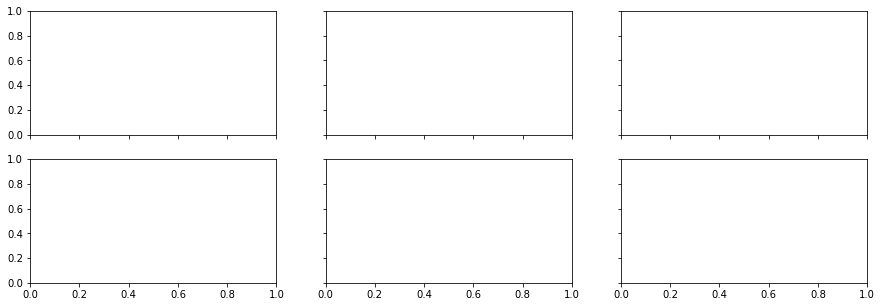

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5), sharex=True, sharey=True)
axs = np.array(ax)
metric = 'congestion_mean'
variations = list(itertools.product(['congestion', 'distance'], [0.0, 0.1, 0.3]))
    
# Pick a random incident
# df = verification_dfs.dropna()

# Get a list of all incidents
fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
df_incidents_gt = pd.read_pickle(fp)

incident = df_incidents_gt.sample(1)
display(incident)

incident_ts = incident.index
incident_month = incident_ts.month.values[0]
incident_day = incident_ts.day.values[0]
incident_XDSegID = incident.iloc[0]['XDSegID']

incident_center = clusters_df[clusters_df['XDSegID'] == incident_XDSegID]['center'].values[0]
circular_bounds = incident_center.buffer(factor * neighbor_range)
sub_cluster_df = clusters_df[clusters_df['geometry'].within(circular_bounds)]

segments_to_check = sub_cluster_df['XDSegID'].unique().tolist()
segments_to_check.insert(0, incident_XDSegID)

df_overall_all = df_overall[incident_month - 1]
speeds_df = df_overall_all[(df_overall_all['month'] == incident_month) & 
                           (df_overall_all['day'] == incident_day) & 
                           (df_overall_all['XDSegID'].isin(segments_to_check))]

speeds_df = speeds_df.set_index('time_local')

incident_ts = pd.Timestamp(incident_ts.values[0])
# Time window
before = incident_ts - pd.Timedelta(f'{time_window}h')
after  = incident_ts + pd.Timedelta(f'{time_window + 0.25}h')

# Whole day
# before = incident_ts.replace(hour=6, minute=0, second=0)
# after  = incident_ts.replace(hour=21, minute=0, second=0)

for i, ax in enumerate(axs.reshape(-1)):    
    test_priority = variations[i][0]
    test_threshold = variations[i][1]
    
    fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{incident_month}_{test_priority}_{test_threshold}_verified.pkl')
    verification_dfs = pd.read_pickle(fp)
    verification_dfs = verification_dfs.dropna()
    verification_dfs = verification_dfs[(verification_dfs['incident_ts'] == incident_ts)]

    if verification_dfs.empty:
        ax.text(0.5, 0.5,'No congestion detected', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    else:
        verification_dfs = verification_dfs.iloc[0]
        period_data = speeds_df[pd.Timestamp(before):pd.Timestamp(after)][metric]
        
        ax.vlines(x=incident_ts, 
                  ymin=-period_data.max(), 
                  ymax=period_data.max(), 
                  colors='blue', ls='-.', lw=1, alpha=1.0)

        period_mean = period_data.mean()
        ax.plot(period_data, label='congestion')

        slope_diff = period_data.shift(-1) - period_data
        ax.plot(slope_diff, ls='--', label='slope', lw=1.0, alpha=0.8)

#         print(variations[i])
        ax.hlines(y=0.0, 
              xmin=pd.Timestamp(verification_dfs.detected_ts_start), 
              xmax=pd.Timestamp(verification_dfs.detected_ts_end), color='red', lw=20, ls='-')

    ax.set_title(f'{variations[i][0]} priority:{variations[i][1]} threshold')

    ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    
#     ax.xaxis.set_major_locator(dates.HourLocator(interval = 3))
#     ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
#     ax.xaxis.set_minor_locator(dates.HourLocator(interval = 1))
##     ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))

custom_lines = [
                Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='gray', lw=1, ls='--'),
                Line2D([0], [0], color='blue', lw=1, ls='-.'),
               ]

ax.legend(custom_lines, ['congestion', 'slope_diff', 'incident'])

fig.suptitle('Comparing congestion detection', fontsize=15)
fig.tight_layout()

fp = os.path.join(img_dir, 'incident_verification_sample2.png')
plt.savefig(fp, dpi=200)
# plt.show()

# Data analysis
* Sticking with `distance` priority with `0.1` congestion threshold

In [20]:
# Load all verifications

verification_dfs = []

test_priority = 'distance'
test_threshold = 0.1

incidents_without_congestion_total = 0
for month in range(1, 13):
    fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{month}_{test_priority}_{test_threshold}_verified.pkl')
    df = pd.read_pickle(fp)
    df['incident_id'] = df.incident_ts.astype(str) + ':' + df['incident_XDSegID'].astype(str) #2019-01-01 01:05:00
    verification_dfs.append(df)

verification_dfs = pd.concat([df for df in verification_dfs])
verification_dfs = verification_dfs.reset_index()
verification_dfs = verification_dfs.drop(['index'], axis=1)

verification_dfs['occurred'] = (verification_dfs['detected_ts_start'] - verification_dfs['incident_ts']).dt.total_seconds()
verification_dfs['occurred'] = np.where(verification_dfs['occurred'] > 0, 'after', 'before')
# print(verification_dfs[verification_dfs['occurred'] == 'before'].shape)
# print(verification_dfs[verification_dfs['occurred'] == 'after'].shape)

unverified_incidents = verification_dfs['detected_XDSegID'].isnull().sum()
verified_incidents = verification_dfs.shape[0] - unverified_incidents

print(f"Priority: {test_priority}:{test_threshold}")
print(f"Total: {verification_dfs.shape[0]}")
print(f"Verified: {verified_incidents}")
print(f"Missed: {unverified_incidents}")
# verification_dfs

Priority: distance:0.1
Total: 8106
Verified: 6288
Missed: 1818


In [27]:
verification_dfs.dropna()

,incident_ts,incident_XDSegID,detected_XDSegID,detected_ts_start,detected_ts_end,detected_distance,detected_congestion,detected_duration,incident_id,occurred
1,2019-01-01 01:15:00,441420536,4.414205e+08,2019-01-01 02:10:00,2019-01-01 02:20:00,0 days 00:55:00,0.307692,10.0,2019-01-01 01:15:00:441420536,after
3,2019-01-01 02:05:00,1524395080,1.524395e+09,2019-01-01 02:25:00,2019-01-01 02:45:00,0 days 00:20:00,0.454545,20.0,2019-01-01 02:05:00:1524395080,after
5,2019-01-01 18:40:00,429334934,4.293349e+08,2019-01-01 18:30:00,2019-01-01 18:45:00,0 days 00:10:00,0.179487,15.0,2019-01-01 18:40:00:429334934,before
6,2019-01-01 18:40:00,449575014,4.495750e+08,2019-01-01 18:30:00,2019-01-01 18:55:00,0 days 00:10:00,0.105263,25.0,2019-01-01 18:40:00:449575014,before
8,2019-01-01 23:05:00,1524482617,1.524483e+09,2019-01-01 22:35:00,2019-01-01 23:15:00,0 days 00:30:00,0.200000,40.0,2019-01-01 23:05:00:1524482617,before
...,...,...,...,...,...,...,...,...,...,...
8100,2019-12-31 18:20:00,429335034,4.293350e+08,2019-12-31 18:25:00,2019-12-31 18:40:00,0 days 00:05:00,0.678571,15.0,2019-12-31 18:20:00:429335034,after
8102,2019-12-31 21:05:00,449631121,4.496311e+08,2019-12-31 21:20:00,2019-12-31 22:05:00,0 days 00:15:00,0.290323,45.0,2019-12-31 21:05:00:449631121,after
8103,2019-12-31 21:50:00,449617510,4.496175e+08,2019-12-31 21:00:00,2019-12-31 21:25:00,0 days 00:50:00,0.230769,25.0,2019-12-31 21:50:00:449617510,before
8104,2019-12-31 21:50:00,449617535,4.496175e+08,2019-12-31 21:50:00,2019-12-31 22:30:00,0 days 00:00:00,0.629630,40.0,2019-12-31 21:50:00:449617535,before


In [28]:
df['detected_distance'].dt.total_seconds().div(60).astype(int)

1       55
3       20
5       10
6       10
8       30
        ..
8100     5
8102    15
8103    50
8104     0
8105     0
Name: detected_distance, Length: 6288, dtype: int64

<AxesSubplot:>

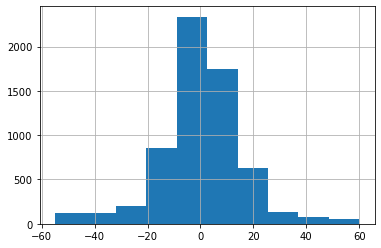

In [39]:
df['det_dist_minutes'].hist()

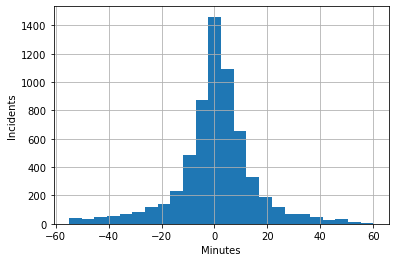

In [37]:
# Load all incidents
fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
df_incidents_gt = pd.read_pickle(fp)

# Load results
# Graph minutes before/after
df = verification_dfs.dropna()
df['det_dist_minutes'] = df['detected_distance'].dt.total_seconds().div(60).astype(int)
df['det_dist_minutes'] = np.where(df['occurred'] == 'before', df['det_dist_minutes'] * -1, df['det_dist_minutes'])
ax = df['det_dist_minutes'].hist(bins=len(df['det_dist_minutes'].unique()))
ax.set_xlabel("Minutes")
# ax.set_title("Time congestion formed with respect to ground truth")
ax.set_ylabel("Incidents")
fp = os.path.join(img_dir, 'incident_verification_times.eps')
plt.savefig(fp, dpi=1000, bbox_inches='tight', format='eps')

Priority: congestion:0.0
Total: 8106
Verified: 6560
Missed: 1546

Priority: congestion:0.1
Total: 8106
Verified: 6288
Missed: 1818

Priority: congestion:0.3
Total: 8106
Verified: 4907
Missed: 3199

Priority: distance:0.0
Total: 8106
Verified: 6560
Missed: 1546

Priority: distance:0.1
Total: 8106
Verified: 6288
Missed: 1818

Priority: distance:0.3
Total: 8106
Verified: 4907
Missed: 3199



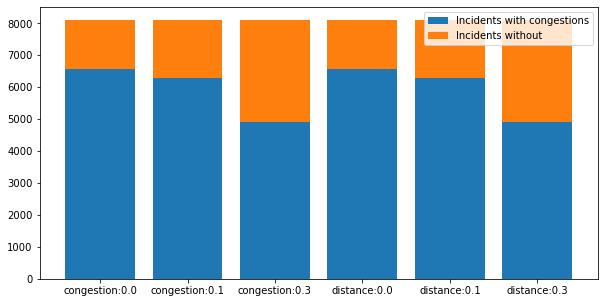

In [870]:
fig, ax = plt.subplots(figsize=(10, 5))

metric = 'congestion_mean'
variations = list(itertools.product(['congestion', 'distance'], [0.0, 0.1, 0.3]))

fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
df_incidents_gt = pd.read_pickle(fp)
total_incidents = df_incidents_gt.shape[0]

total_incidents_arr = [total_incidents] * len(variations)
verified_incidents_arr = []
unverified_incidents_arr = []

verification_dfs_arr = []
for v in variations:
    test_priority = v[0]
    test_threshold = v[1]
    verification_dfs = []
    for month in range(1, 13):
        fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{month}_{test_priority}_{test_threshold}_verified.pkl')
        df = pd.read_pickle(fp)
        df['incident_id'] = df.incident_ts.astype(str) + ':' + df['incident_XDSegID'].astype(str) #2019-01-01 01:05:00
        verification_dfs.append(df)

    verification_dfs = pd.concat([df for df in verification_dfs])
    verification_dfs = verification_dfs.reset_index()
    verification_dfs = verification_dfs.drop(['index'], axis=1)
    
    verification_dfs_arr.append(verification_dfs)
    
    unverified_incidents = verification_dfs['detected_XDSegID'].isnull().sum()
    verified_incidents = verification_dfs.shape[0] - unverified_incidents
    verified_incidents_arr.append(verified_incidents)
    unverified_incidents_arr.append(unverified_incidents)
    
    print(f"Priority: {test_priority}:{test_threshold}")
    print(f"Total: {verification_dfs.shape[0]}")
    print(f"Verified: {verified_incidents}")
    print(f"Missed: {unverified_incidents}")
    print()
# ax.plot(total_incidents_arr, marker='o')
# ax.plot(verified_incidents_arr, marker='^')
# ax.plot(unverified_incidents_arr, marker='*')
labels = [f"{v[0]}:{v[1]}" for v in variations]

ax.bar(x=labels, height=verified_incidents_arr, label='Incidents with congestions')
# ax.bar(variations, verified_incidents_arr, 0.25, label='Verified')
ax.bar(labels, unverified_incidents_arr, label='Incidents without', bottom=verified_incidents_arr)
ax.legend()
fp = os.path.join(img_dir, 'incident_verification_counts.png')
plt.savefig(fp, dpi=200)

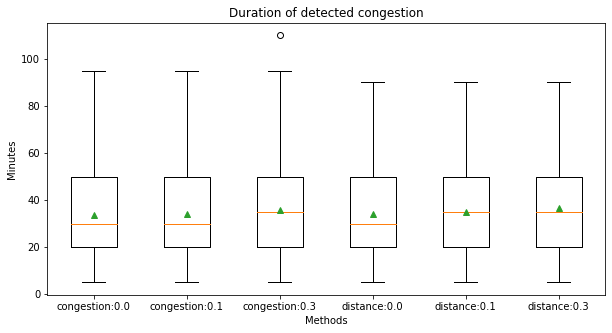

In [716]:
fig, ax = plt.subplots(figsize=(10, 5))

data = []
for i, v in enumerate(variations):
    df = verification_dfs_arr[i]
    df = df.dropna()
    data.append(df.detected_duration.to_numpy())
#     print(df.detected_duration.mean())
ax.boxplot(data, showfliers=True, showmeans=True, showcaps=True)

ax.set_xticklabels(labels)
ax.set_xlabel("Methods")
ax.set_ylabel("Minutes")
ax.set_title("Duration of detected congestion")

fp = os.path.join(img_dir, 'incident_verification_durations.png')
plt.savefig(fp, dpi=200)

In [1]:
verification_dfs

NameError: name 'verification_dfs' is not defined

## Plotting the `unverified` incidents

In [921]:
verification_dfs = []

test_priority = 'distance'
test_threshold = 0.0

for month in range(1, 13):
    fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{month}_{test_priority}_{test_threshold}_verified.pkl')
    df = pd.read_pickle(fp)
    df['incident_id'] = df.incident_ts.astype(str) + ':' + df['incident_XDSegID'].astype(str) #2019-01-01 01:05:00
    verification_dfs.append(df)

verification_dfs = pd.concat([df for df in verification_dfs])
verification_dfs = verification_dfs.reset_index()
verification_dfs = verification_dfs.drop(['index'], axis=1)

In [841]:
for k, v in verification_dfs[verification_dfs['detected_XDSegID'].isnull()].iterrows():
    print(k, v)
    
    print(incident)
    break

0 incident_ts                       2019-01-01 01:10:00
incident_XDSegID                           1524461437
detected_XDSegID                                  NaN
detected_ts_start                                 NaT
detected_ts_end                                   NaT
detected_distance                                 NaT
detected_congestion                               NaN
detected_duration                                 NaN
incident_id            2019-01-01 01:10:00:1524461437
Name: 0, dtype: object
incident_ts                      2019-11-01 05:40:00
incident_XDSegID                           449617458
detected_XDSegID                                 NaN
detected_ts_start                                NaT
detected_ts_end                                  NaT
detected_distance                                NaT
detected_congestion                              NaN
detected_duration                                NaN
incident_id            2019-11-01 05:40:00:449617458
Name: 6724, 

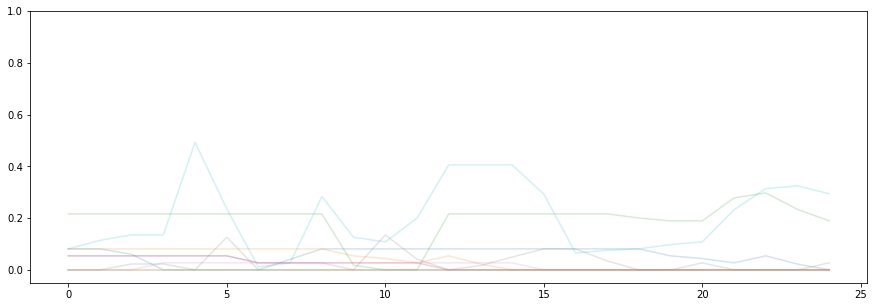

In [858]:
fig, ax = plt.subplots(figsize=(15, 5))

for k, incident in verification_dfs[verification_dfs['detected_XDSegID'].isnull()][0:10].iterrows():
    incident_ts = incident.incident_ts
    incident_month = incident_ts.month
    incident_day = incident_ts.day
    incident_XDSegID = incident['incident_XDSegID']

    df_overall_all = df_overall[incident_month - 1]
    speeds_df = df_overall_all[(df_overall_all['month'] == incident_month) & 
                               (df_overall_all['day'] == incident_day) & 
                               (df_overall_all['XDSegID'].isin(segments_to_check))]
    speeds_df = speeds_df.set_index('time_local')

    # Time window
    before = incident_ts - pd.Timedelta(f'{time_window}h')
    after  = incident_ts + pd.Timedelta(f'{time_window}h')
    
    period_data = speeds_df[pd.Timestamp(before):pd.Timestamp(after)][metric].to_numpy()
    ax.plot(period_data, label='congestion', alpha=0.2)

#     ax.vlines(x=incident_ts, 
#               ymin=-period_data.max(), 
#               ymax=period_data.max(), 
#               colors='blue', ls='-.', lw=1, alpha=1.0)

#     slope_diff = period_data.shift(-1) - period_data
#     ax.plot(slope_diff, ls='--', label='slope', lw=1.0, alpha=0.8)
#     break
ax.set_ylim(-0.05, 1.0)
# ax.set_title(f'{variations[i][0]} priority:{variations[i][1]} threshold')

# ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
# ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
fp = os.path.join(img_dir, 'unverified_congestions.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [945]:
non_na_df

,incident_ts,incident_XDSegID,detected_XDSegID,detected_ts_start,detected_ts_end,detected_distance,detected_congestion,detected_duration,incident_id
1,2019-01-01 01:15:00,441420536,4.414205e+08,2019-01-01 02:10:00,2019-01-01 02:20:00,0 days 00:55:00,0.307692,10.0,2019-01-01 01:15:00:441420536
3,2019-01-01 02:05:00,1524395080,1.524395e+09,2019-01-01 02:25:00,2019-01-01 02:45:00,0 days 00:20:00,0.454545,20.0,2019-01-01 02:05:00:1524395080
5,2019-01-01 18:40:00,429334934,4.293349e+08,2019-01-01 18:30:00,2019-01-01 18:45:00,0 days 00:10:00,0.179487,15.0,2019-01-01 18:40:00:429334934
6,2019-01-01 18:40:00,449575014,4.495750e+08,2019-01-01 18:30:00,2019-01-01 18:55:00,0 days 00:10:00,0.105263,25.0,2019-01-01 18:40:00:449575014
8,2019-01-01 23:05:00,1524482617,1.524483e+09,2019-01-01 22:35:00,2019-01-01 23:15:00,0 days 00:30:00,0.200000,40.0,2019-01-01 23:05:00:1524482617
...,...,...,...,...,...,...,...,...,...
8100,2019-12-31 18:20:00,429335034,4.293350e+08,2019-12-31 18:25:00,2019-12-31 18:40:00,0 days 00:05:00,0.678571,15.0,2019-12-31 18:20:00:429335034
8102,2019-12-31 21:05:00,449631121,4.496311e+08,2019-12-31 21:20:00,2019-12-31 22:05:00,0 days 00:15:00,0.290323,45.0,2019-12-31 21:05:00:449631121
8103,2019-12-31 21:50:00,449617510,4.496175e+08,2019-12-31 21:00:00,2019-12-31 21:25:00,0 days 00:50:00,0.230769,25.0,2019-12-31 21:50:00:449617510
8104,2019-12-31 21:50:00,449617535,4.496175e+08,2019-12-31 21:50:00,2019-12-31 22:30:00,0 days 00:00:00,0.629630,40.0,2019-12-31 21:50:00:449617535


incident_ts                       2019-07-02 22:15:00
incident_XDSegID                           1524308348
detected_XDSegID                          1.52431e+09
detected_ts_start                 2019-07-02 21:55:00
detected_ts_end                   2019-07-02 22:50:00
detected_distance                     0 days 00:20:00
detected_congestion                          0.539848
detected_duration                                  55
incident_id            2019-07-02 22:15:00:1524308348
Name: 3876, dtype: object


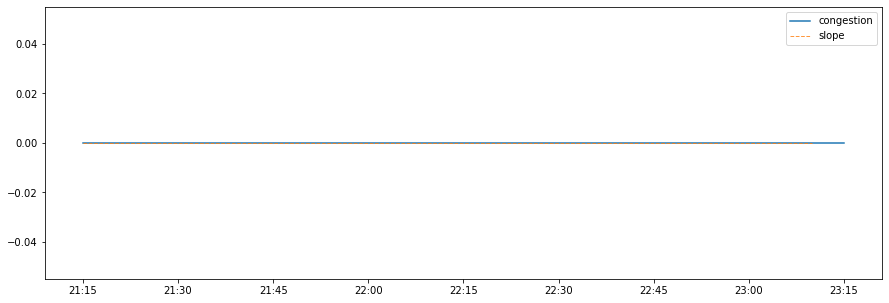

In [966]:
fig, ax = plt.subplots(figsize=(15, 5))
non_na_df = verification_dfs.dropna()
incident = non_na_df.sample(1).iloc[0]
# incident = verification_dfs[verification_dfs['detected_XDSegID'].isnull()].sample(1).iloc[0]
# incident = verification_dfs[verification_dfs['incident_id'] == '2019-09-15 01:20:00:1524453968'].iloc[0]
print(incident)
incident_ts = incident.incident_ts
incident_month = incident_ts.month
incident_day = incident_ts.day
incident_XDSegID = incident['incident_XDSegID']

df_overall_all = df_overall[incident_month - 1]
speeds_df = df_overall_all[(df_overall_all['month'] == incident_month) & 
                           (df_overall_all['day'] == incident_day) & 
                           (df_overall_all['XDSegID'].isin(segments_to_check))]
speeds_df = speeds_df.set_index('time_local')

# Time window
before = incident_ts - pd.Timedelta(f'{time_window}h')
after  = incident_ts + pd.Timedelta(f'{time_window}h')

# ### Visualizing speed
# ax1 = ax.twinx()
# speed_data = speeds_df[pd.Timestamp(before):pd.Timestamp(after)]['speed_mean']
# ax1.plot(speed_data, label='congestion', ls='-.')
# ax1.vlines(x=incident_ts, 
#           ymin=0, 
#           ymax=speed_data.max(), 
#           colors='red', ls='-.', lw=1, alpha=1.0)
# ax1.yaxis.label.set_color('red')
# ax1.tick_params(colors='red', which='both')
# ### Visualizing speed

period_data = speeds_df[pd.Timestamp(before):pd.Timestamp(after)][metric]
ax.plot(period_data, label='congestion')

ax.vlines(x=incident_ts, 
          ymin=-period_data.max(), 
          ymax=period_data.max(), 
          colors='blue', ls='-.', lw=1, alpha=1.0)

slope_diff = period_data.shift(-1) - period_data
ax.plot(slope_diff, ls='--', label='slope', lw=1.0, alpha=0.8)
ax.legend()
# ax.set_title(f'{variations[i][0]} priority:{variations[i][1]} threshold')

ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

fp = os.path.join(img_dir, 'unverified_congestion_single.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5), sharex=True, sharey=True)
axs = np.array(ax)
metric = 'congestion_mean'
variations = list(itertools.product(['congestion', 'distance'], [0.0, 0.1, 0.3]))
    
# Pick a random incident
# df = verification_dfs.dropna()

# Get a list of all incidents
fp = os.path.join(data_dir, "all_incidents_ground_truth.pkl")
df_incidents_gt = pd.read_pickle(fp)

incident = df_incidents_gt.sample(1)
display(incident)

incident_ts = incident.index
incident_month = incident_ts.month.values[0]
incident_day = incident_ts.day.values[0]
incident_XDSegID = incident.iloc[0]['XDSegID']

incident_center = clusters_df[clusters_df['XDSegID'] == incident_XDSegID]['center'].values[0]
circular_bounds = incident_center.buffer(factor * neighbor_range)
sub_cluster_df = clusters_df[clusters_df['geometry'].within(circular_bounds)]

segments_to_check = sub_cluster_df['XDSegID'].unique().tolist()
segments_to_check.insert(0, incident_XDSegID)

df_overall_all = df_overall[incident_month - 1]
speeds_df = df_overall_all[(df_overall_all['month'] == incident_month) & 
                           (df_overall_all['day'] == incident_day) & 
                           (df_overall_all['XDSegID'].isin(segments_to_check))]

speeds_df = speeds_df.set_index('time_local')

incident_ts = pd.Timestamp(incident_ts.values[0])
# Time window
before = incident_ts - pd.Timedelta(f'{time_window}h')
after  = incident_ts + pd.Timedelta(f'{time_window + 0.25}h')

# Whole day
# before = incident_ts.replace(hour=6, minute=0, second=0)
# after  = incident_ts.replace(hour=21, minute=0, second=0)

for i, ax in enumerate(axs.reshape(-1)):    
    test_priority = variations[i][0]
    test_threshold = variations[i][1]
    
    fp = os.path.join(data_dir, 'incident_congestion_verification', f'{test_priority}_{test_threshold}', f'{incident_month}_{test_priority}_{test_threshold}_verified.pkl')
    verification_dfs = pd.read_pickle(fp)
    verification_dfs = verification_dfs.dropna()
    verification_dfs = verification_dfs[(verification_dfs['incident_ts'] == incident_ts)]

    if verification_dfs.empty:
        ax.text(0.5, 0.5,'No congestion detected', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    else:
        verification_dfs = verification_dfs.iloc[0]
        period_data = speeds_df[pd.Timestamp(before):pd.Timestamp(after)][metric]
        
        ax.vlines(x=incident_ts, 
                  ymin=-period_data.max(), 
                  ymax=period_data.max(), 
                  colors='blue', ls='-.', lw=1, alpha=1.0)

        period_mean = period_data.mean()
        ax.plot(period_data, label='congestion')

        slope_diff = period_data.shift(-1) - period_data
        ax.plot(slope_diff, ls='--', label='slope', lw=1.0, alpha=0.8)

#         print(variations[i])
        ax.hlines(y=0.0, 
              xmin=pd.Timestamp(verification_dfs.detected_ts_start), 
              xmax=pd.Timestamp(verification_dfs.detected_ts_end), color='red', lw=20, ls='-')

    ax.set_title(f'{variations[i][0]} priority:{variations[i][1]} threshold')

    ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    
#     ax.xaxis.set_major_locator(dates.HourLocator(interval = 3))
#     ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
#     ax.xaxis.set_minor_locator(dates.HourLocator(interval = 1))
##     ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))

custom_lines = [
                Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='gray', lw=1, ls='--'),
                Line2D([0], [0], color='blue', lw=1, ls='-.'),
               ]

ax.legend(custom_lines, ['congestion', 'slope_diff', 'incident'])

fig.suptitle('Comparing congestion detection', fontsize=15)
fig.tight_layout()

# fp = os.path.join(img_dir, 'incident_verification_sample.png')
# plt.savefig(fp, dpi=200)
# plt.show()

## Notes:
* What defines a congestion? How large does the speed decrease need to be before it can be categorized as a congestion?

(Timestamp('2019-01-01 02:05:00'), Timestamp('2019-01-01 02:20:00'))

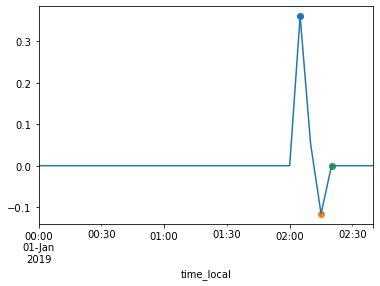

In [488]:
# Function to find max and min and then 0 after min. 
# to get the dip
# fig, ax = plt.subplots()
# slope_diff.plot(ax=ax)
ax = slope_diff.plot()

extremas_df = {'ts': [], 'val': [], 'ind': [],
               'segment': [], 'status': []}

_maxs = argrelextrema(slope_diff.to_numpy(), np.greater)[0].tolist()
_mins = argrelextrema(slope_diff.to_numpy(), np.less)[0].tolist()

for r in _maxs:
    _a = segment_df[pd.Timestamp(before):pd.Timestamp(after)].iloc[r]
    extremas_df['ts'].append(_a.name)
    extremas_df['val'].append(slope_diff[r])
    extremas_df['ind'].append(r)
    extremas_df['segment'].append(segment)
    extremas_df['status'].append('max')
    ax.scatter(x=_a.name, y=slope_diff[r], marker='o')

for r in _mins:
    _a = segment_df[pd.Timestamp(before):pd.Timestamp(after)].iloc[r]
    extremas_df['ts'].append(_a.name)
    extremas_df['val'].append(slope_diff[r])
    extremas_df['ind'].append(r)
    extremas_df['segment'].append(segment)
    extremas_df['status'].append('min')
    ax.scatter(x=_a.name, y=slope_diff[r], marker='o')

extremas_df = pd.DataFrame(extremas_df)

next_z = (slope_diff.iloc[28:] == 0).sort_index().index[0]

ax.scatter(x=next_z, y=0, marker='o')

first_zero = slope_diff.index.get_loc(next_z)
segment_df[pd.Timestamp(before):pd.Timestamp(after)].iloc[25].name, segment_df[pd.Timestamp(before):pd.Timestamp(after)].iloc[28].name